In [0]:
%matplotlib inline

In [0]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. Loading and normalizing CIFAR10 Dataset

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [0]:
import torch as th
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

Seed the random generator to have reproducible results:

In [0]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


### Define subset of the dataset (so it is faster to train)

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [12]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. Define a Convolution Neural Network


In [0]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

#### Simple Convolutional Neural Network

ConvNet with one convolution layer followed by a max pooling operation,
one fully connected layer and an output layer

In [0]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(SimpleConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x32x32 input image to a 18x16x16 volume)
        self.fc1 = nn.Linear(18 * 16 * 16, 64) 
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        # 18x16x16 -> 4608
        x = x.view(-1, 18 * 16 * 16)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

#### Linear Classifier

In [0]:
class LinearClassifier(nn.Module):
    """
    Linear Classifier
    """
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(32 * 32 * 3, 10)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        x = x.view(x.size(0), -1)
        return self.linear(x)

### 3. Define a loss function and optimizer

Let's use a Classification Cross-Entropy loss and ADAM (optionally, SGD with momentum). You can read more about  [optimization methods](https://pytorch.org/docs/stable/optim.html).



In [0]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.01)
    return criterion, optimizer

### 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, feed the inputs to the network, and optimize



#### Data loader

In [0]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

#### Training loop
The training script: it takes ~10s per epoch with batch_size = 32

In [0]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [19]:
net = SimpleConvolutionalNetwork()

train_history, val_history = train(net, batch_size=32, n_epochs=30, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 30
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.12 took: 0.61s
Epoch 1, 20% 	 train_loss: 1.86 took: 0.52s
Epoch 1, 30% 	 train_loss: 1.80 took: 0.52s
Epoch 1, 40% 	 train_loss: 1.76 took: 0.52s
Epoch 1, 50% 	 train_loss: 1.64 took: 0.52s
Epoch 1, 60% 	 train_loss: 1.59 took: 0.49s
Epoch 1, 70% 	 train_loss: 1.59 took: 0.53s
Epoch 1, 80% 	 train_loss: 1.58 took: 0.51s
Epoch 1, 90% 	 train_loss: 1.57 took: 0.54s
Validation loss = 1.44
Epoch 2, 10% 	 train_loss: 1.45 took: 0.60s
Epoch 2, 20% 	 train_loss: 1.48 took: 0.52s
Epoch 2, 30% 	 train_loss: 1.50 took: 0.53s
Epoch 2, 40% 	 train_loss: 1.47 took: 0.50s
Epoch 2, 50% 	 train_loss: 1.47 took: 0.53s
Epoch 2, 60% 	 train_loss: 1.43 took: 0.52s
Epoch 2, 70% 	 train_loss: 1.40 took: 0.51s
Epoch 2, 80% 	 train_loss: 1.42 took: 0.52s
Epoch 2, 90% 	 train_loss: 1.47 took: 0.53s
Validation loss = 1.41
Epoch 3, 10% 	 train_loss: 1.41 took: 0.66s
Epoch 3, 20% 	 train_loss: 1.36 took: 0.5

Now, let's look at the evolution of the losses

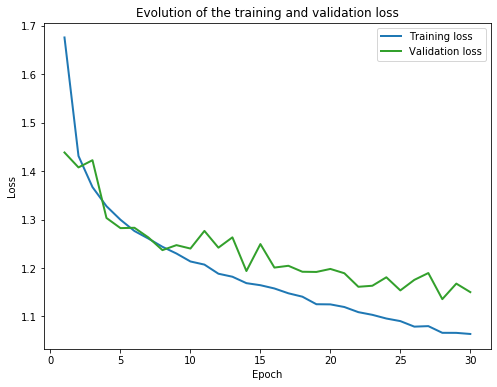

In [20]:
plot_losses(train_history, val_history)

In [21]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 20000 train images: 67.12 %
Accuracy of the network on the 5000 validation images: 60.42 %
Accuracy of the network on the 5000 test images: 59.90 %


That initial 59.78 % on the test set of images looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.
As a baseline, a linear model achieves around 30% accuracy.

What are the classes that performed well, and the classes that did not perform well?



In [22]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        62.91   
car          75.64   
bird         49.61   
cat          33.80   
deer         37.87   
dog          49.80   
frog         74.54   
horse        67.47   
ship         82.14   
truck        65.30   


### Confusion Matrix

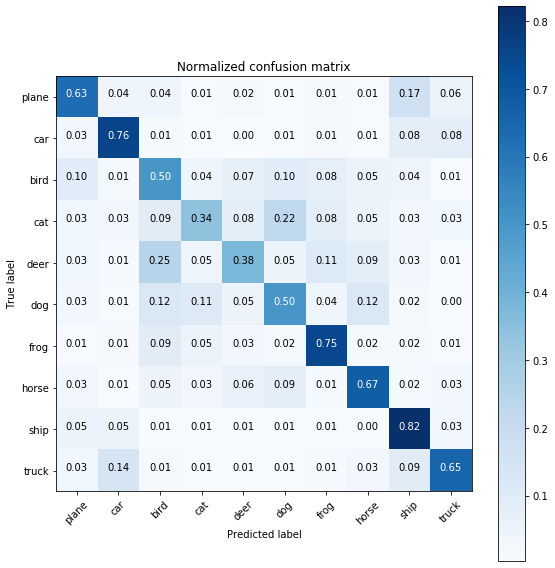

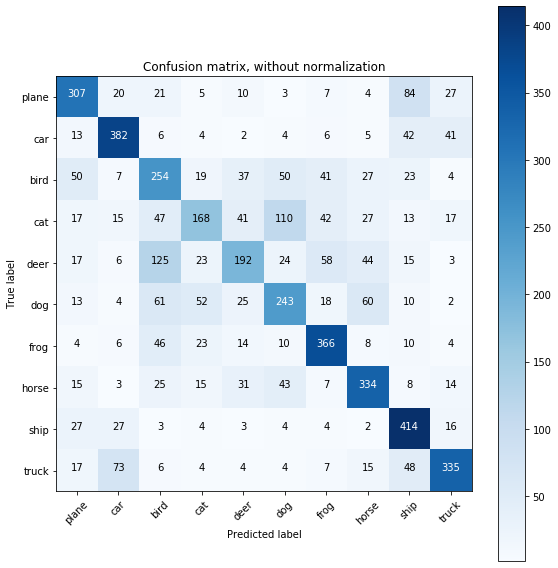

In [23]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

# Few experiments from the report
Below three models we used in the report. We just redefine the `MyConvolutionalNetwork` class as we go.

### 1. Default (dummy) model 

Below is the neural network you have to edit:

In [0]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(p=0.35)
        
        # Size of the output of the last convolution:
        self.flattened_size = 16 * 8 * 8
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        
        #### START CODE: USE YOUR NEW LAYERS HERE ####
        # x = F.relu(self.conv2(self.bn1(x)))
        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.pool1(x)
        
        #### END CODE ####
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

In [47]:
net = MyConvolutionalNetwork()
print(net)

MyConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.35, inplace=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [48]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=20, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 20
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.34 took: 0.66s
Epoch 1, 20% 	 train_loss: 2.33 took: 0.56s
Epoch 1, 30% 	 train_loss: 2.32 took: 0.53s
Epoch 1, 40% 	 train_loss: 2.30 took: 0.55s
Epoch 1, 50% 	 train_loss: 2.27 took: 0.57s
Epoch 1, 60% 	 train_loss: 2.23 took: 0.54s
Epoch 1, 70% 	 train_loss: 2.16 took: 0.54s
Epoch 1, 80% 	 train_loss: 2.09 took: 0.54s
Epoch 1, 90% 	 train_loss: 2.07 took: 0.55s
Validation loss = 1.96
Epoch 2, 10% 	 train_loss: 1.98 took: 0.65s
Epoch 2, 20% 	 train_loss: 1.96 took: 0.61s
Epoch 2, 30% 	 train_loss: 1.90 took: 0.61s
Epoch 2, 40% 	 train_loss: 1.91 took: 0.55s
Epoch 2, 50% 	 train_loss: 1.89 took: 0.54s
Epoch 2, 60% 	 train_loss: 1.85 took: 0.54s
Epoch 2, 70% 	 train_loss: 1.82 took: 0.55s
Epoch 2, 80% 	 train_loss: 1.81 took: 0.56s
Epoch 2, 90% 	 train_loss: 1.78 took: 0.54s
Validation loss = 1.71
Epoch 3, 10% 	 train_loss: 1.74 took: 0.65s
Epoch 3, 20% 	 train_loss: 1.73 took: 0.5

##### Losses Plot

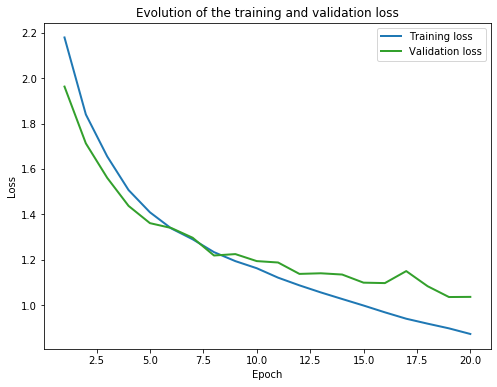

In [49]:
plot_losses(train_history, val_history)

##### Accuracy of the trained model

In [50]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 70.58 %
Accuracy of the network on the 5000 validation images: 63.20 %
Accuracy of the network on the 5000 test images: 62.90 %


In [51]:
confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        71.11   
car          78.81   
bird         47.66   
cat          45.67   
deer         58.19   
dog          52.05   
frog         66.40   
horse        64.85   
ship         76.19   
truck        65.89   


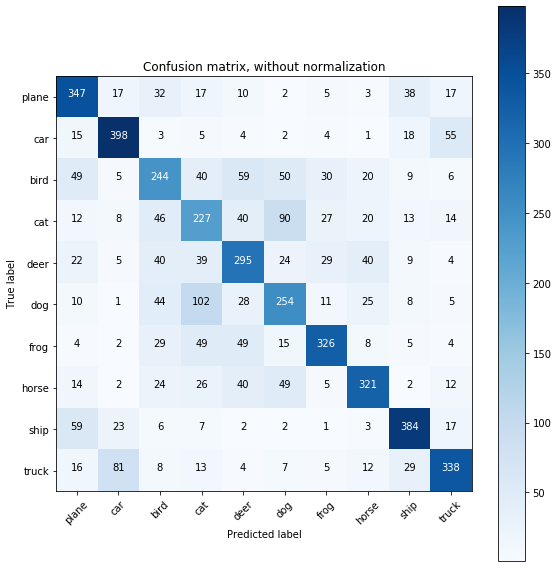

In [52]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

## Truncated-adaptated VGG16

![](https://markdown.data-ensta.fr/uploads/upload_ec7f0b1ae7aaa3b77c66d5f29f992087.png)

In [0]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        self.conv_layer = nn.Sequential(
        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.Dropout2d(p=0.05),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Conv Layer block 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Conv Layer block 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        # nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        )
        ### END CODE ###
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)
        return x

In [32]:
net = MyConvolutionalNetwork()
print(net)

MyConvolutionalNetwork(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout2d(p=0.05, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(256, 256, kernel_s

In [33]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=30, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 30
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.08 took: 1.15s
Epoch 1, 20% 	 train_loss: 1.87 took: 0.97s
Epoch 1, 30% 	 train_loss: 1.81 took: 0.96s
Epoch 1, 40% 	 train_loss: 1.79 took: 0.94s
Epoch 1, 50% 	 train_loss: 1.73 took: 0.95s
Epoch 1, 60% 	 train_loss: 1.72 took: 0.99s
Epoch 1, 70% 	 train_loss: 1.63 took: 0.97s
Epoch 1, 80% 	 train_loss: 1.64 took: 0.98s
Epoch 1, 90% 	 train_loss: 1.63 took: 0.95s
Validation loss = 1.47
Epoch 2, 10% 	 train_loss: 1.55 took: 1.05s
Epoch 2, 20% 	 train_loss: 1.51 took: 0.96s
Epoch 2, 30% 	 train_loss: 1.52 took: 0.95s
Epoch 2, 40% 	 train_loss: 1.51 took: 0.94s
Epoch 2, 50% 	 train_loss: 1.43 took: 0.95s
Epoch 2, 60% 	 train_loss: 1.38 took: 0.94s
Epoch 2, 70% 	 train_loss: 1.39 took: 0.96s
Epoch 2, 80% 	 train_loss: 1.40 took: 0.95s
Epoch 2, 90% 	 train_loss: 1.37 took: 0.97s
Validation loss = 1.25
Epoch 3, 10% 	 train_loss: 1.24 took: 1.07s
Epoch 3, 20% 	 train_loss: 1.28 took: 0.9

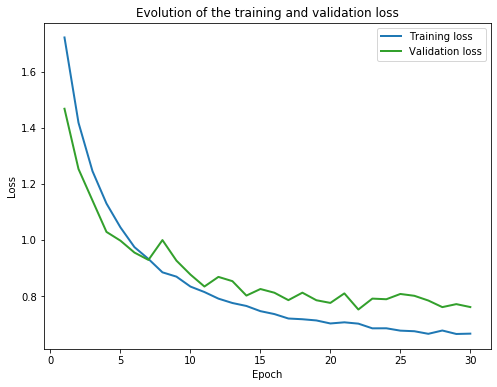

In [34]:
plot_losses(train_history, val_history)

In [35]:
compute_accuracy(net)

Accuracy of the network on the 20000 train images: 73.77 %
Accuracy of the network on the 5000 validation images: 73.52 %
Accuracy of the network on the 5000 test images: 68.88 %


## Adapted Full VGG16

![](https://markdown.data-ensta.fr/uploads/upload_e15d93ea501731ba1de63b127e1d610b.png)

NB: dense layers are not shown in this picture.
This model takes very long time to train so we ran it only once, not in this notebook. Result for 40 epochs is shown in report. You are welcome to run it here.

In [0]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        self.conv_layer = nn.Sequential(
        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.Dropout2d(p=0.05),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Conv Layer block 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=1),
        # Conv Layer block 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),      
        nn.MaxPool2d(kernel_size=2, stride=1),
        # Conv Layer block 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(kernel_size=2, stride=1),
        # Conv Layer block 5
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(kernel_size=2, stride=1),
        )
        ### END CODE ###
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(12*12*512 , 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.1),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)
        return x

In [37]:
net = MyConvolutionalNetwork()
train_history, val_history = train(net, batch_size=32, n_epochs=30, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 30
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 5.09 took: 18.38s
Epoch 1, 20% 	 train_loss: 2.27 took: 18.47s
Epoch 1, 30% 	 train_loss: 2.17 took: 18.27s
Epoch 1, 40% 	 train_loss: 2.06 took: 18.12s
Epoch 1, 50% 	 train_loss: 1.98 took: 18.16s
Epoch 1, 60% 	 train_loss: 1.90 took: 18.27s
Epoch 1, 70% 	 train_loss: 1.88 took: 18.28s
Epoch 1, 80% 	 train_loss: 1.89 took: 18.24s


KeyboardInterrupt: ignored